In [1]:
import numpy as np
import torch,  os
import pandas as pd
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import cv2

In [2]:
# load data

train_df = pd.read_csv(r'./train.csv')
test_df = pd.read_csv(r'./test.csv')
train_picture_path=  r'./train'
test_picture_path = r'./test_images/'

# setting area 
zoom=32
IMG_SIZE = zoom
NUM_CLASSES = 10
GRAYSCALE = False
num_features = 784

In [3]:
train_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [4]:
def load_images(x,zoom , dir_path):
    return cv2.resize(cv2.imread(os.path.join(dir_path , x)),(zoom,zoom))

In [5]:
# Create a Dataset to hold the input data and make it available to dataloader
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i]
        data = np.array(data).astype(np.uint8).reshape(IMG_SIZE, IMG_SIZE, 3)
        
        if self.transforms:
            data = self.transforms(data)
            
            # Also return label if we have it
            if self.y is not None:
                return (data, self.y[i])
            else:
                return data    

In [6]:
train_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [7]:
train_df['Data'] = train_df['ID'].apply(lambda x : load_images(x,zoom , train_picture_path))
test_df['Data'] = test_df['ID'].apply(lambda x : load_images(x , zoom, test_picture_path))

In [8]:
all_train_labels=train_df['Label']
all_train_images = train_df['Data']

test_images = test_df['Data']

# Split training data so we have a small validation set and training set
train_images, val_images, train_labels, val_labels = train_test_split(all_train_images, all_train_labels, test_size=0.2)

# Reindex so we can refer to first element using index 0
train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

In [9]:
# Training Image transformations
train_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
]
)
# Validation Image transformations
val_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
]
)


In [10]:
# Create data loaders
batch_size = 64

train_dataset = MyDataset(train_images, train_labels, train_trans)
val_dataset = MyDataset(val_images, val_labels, val_trans)
test_dataset = MyDataset(test_images, None, val_trans)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


<h1><center> -  ResNet Architecture</center>
<h3><center> ResNet 的架構</center></h3>
<img src='pic/resnet-ex-1-1.png'>

<h3><center> ResNet-18 的架構</center></h3>
  
<img src='pic/resnet-ex-1-2.png'>

<h3><center> ResNet-50 的架構</center></h3>
  
<img src='pic/resnet-ex-1-3.png'>

<h4><center> ResNet- 50 多加一層 conv , bn , relu <center>
    


In [11]:

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        
        return logits



def resnet50(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet50(NUM_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [14]:
# Train the model

epochs = 30

train_losses, val_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Clear last image's results
        optimizer.zero_grad()
        log_ps = model(images)
        loss = F.cross_entropy(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        val_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                log_ps = model(images)
                val_loss +=  F.cross_entropy(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
             "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
             "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader)),
             "Accuracy: {:.3f}".format(accuracy/len(val_loader)))
        

Epoch: 1/30..  Training Loss: 1.993..  Validation Loss: 1.826..  Accuracy: 0.354
Epoch: 2/30..  Training Loss: 1.664..  Validation Loss: 1.610..  Accuracy: 0.449
Epoch: 3/30..  Training Loss: 1.552..  Validation Loss: 1.557..  Accuracy: 0.422
Epoch: 4/30..  Training Loss: 1.426..  Validation Loss: 1.449..  Accuracy: 0.457
Epoch: 5/30..  Training Loss: 1.363..  Validation Loss: 1.431..  Accuracy: 0.454
Epoch: 6/30..  Training Loss: 1.310..  Validation Loss: 1.365..  Accuracy: 0.459
Epoch: 7/30..  Training Loss: 1.251..  Validation Loss: 1.319..  Accuracy: 0.504
Epoch: 8/30..  Training Loss: 1.218..  Validation Loss: 1.355..  Accuracy: 0.490
Epoch: 9/30..  Training Loss: 1.170..  Validation Loss: 1.316..  Accuracy: 0.482
Epoch: 10/30..  Training Loss: 1.127..  Validation Loss: 1.281..  Accuracy: 0.491
Epoch: 11/30..  Training Loss: 1.099..  Validation Loss: 1.227..  Accuracy: 0.525
Epoch: 12/30..  Training Loss: 1.065..  Validation Loss: 1.232..  Accuracy: 0.549
Epoch: 13/30..  Training 

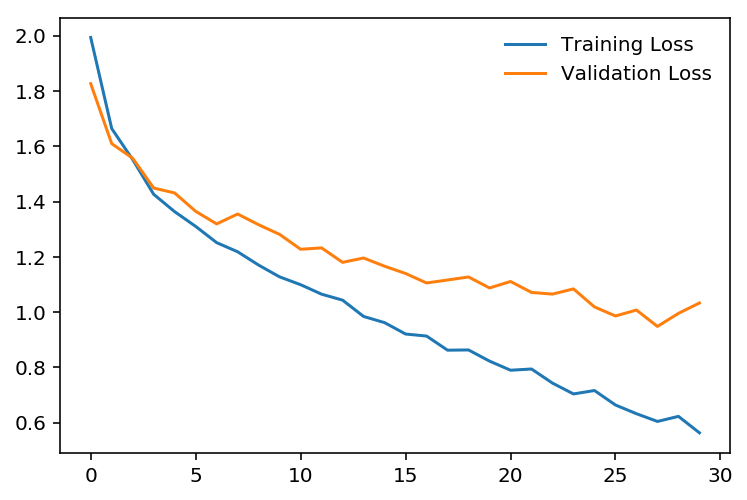

In [15]:
# Plot the losses
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(frameon=False);